# KNN, рак и спам
__Суммарное количество баллов: 12__

__Решение отправлять на `ml.course.practice@gmail.com`__

__Тема письма: `[HSE][ML][MS][HW01] <ФИ>`, где вместо `<ФИ>` указаны фамилия и имя__

В этом домашнем задании Вам предлагается при помощи классификации методом k ближайших соседей научиться отличать тип опухоли в организме, а так же определять сообщения со спамом

In [1]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
import copy
import pandas
from typing import NoReturn, Tuple, List

### Задание 1 (1 балл)
Для начала работы нам необходимо научиться читать набор данных. Всего мы будем работать с двумя наборами данных.

__Cancer.csv__ - выборка данных о пациентах с доброкачественными и злокачественными опухолями. Задача - научиться их отличать.

__Spam.csv__ - набор данных большего размера. Он содержит некоторую статистику по сообщениям, а так же метку, является ли сообщение спамом. Задача - научиться автоматически отличать спам от обычных сообщений.

Реализуйте методы `read_cancer_dataset` и `read_spam_dataset`. Каждый из них принимает на вход путь к набору данных и возвращает выборку `X` и соответствующие метки `y`. Набор данных должен быть упорядочен случайно, т.е. необходимо сделать shuffle.

In [2]:
def read_cancer_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к cancer датасету.

    Returns
    -------
    X : np.array
        Матрица признаков опухолей.
    y : np.array
        Вектор бинарных меток, 1 соответствует доброкачественной опухоли (M), 
        0 --- злокачественной (B).

    
    """
    df = pandas.read_csv(path_to_csv, header=1).sample(frac=1).values
    y = df[:, 0]
    y[y == 'M'] = 1
    y[y == 'B'] = 0
    x = df[:, 1:]
    return x.astype('float64'), y

def read_spam_dataset(path_to_csv: str) -> Tuple[np.array, np.array]:
    """
     
    Parameters
    ----------
    path_to_csv : str
        Путь к spam датасету.

    Returns
    -------
    X : np.array
        Матрица признаков сообщений.
    y : np.array
        Вектор бинарных меток, 
        1 если сообщение содержит спам, 0 если не содержит.
    
    """
    df = pandas.read_csv(path_to_csv, header=1).sample(frac=1).values
    y = df[:, -1]
    x = df[:, :-1]
    return x, y.astype('int8')

In [3]:
X, y = read_cancer_dataset("cancer.csv")
X.shape

(568, 30)

In [4]:
read_spam_dataset('spam.csv')[0].shape

(4600, 57)

### Задание 2  (1 балл)
Начиная работать с данными, нам необходимо их предобработать и подготовить. В частности, нам необходимо разделить выборку на две: тренировочную и тестовую. Тренировочная выборка необходима для обучения алгоритма, а тестовая для проверки результатов обучения. Обычно используют коэффициент разделения `0.9`.

Необходимо вернуть кортеж из `X_train`, `y_train`, `X_test` и `y_test`

In [5]:
def train_test_split(X: np.array, y: np.array, ratio: float
                     ) -> Tuple[np.array, np.array, np.array, np.array]:
    """

    Parameters
    ----------
    X : np.array
        Матрица признаков.
    y : np.array
        Вектор меток.
    ratio : float
        Коэффициент разделения.

    Returns
    -------
    X_train : np.array
        Матрица признаков для train выборки.
    y_train : np.array
        Вектор меток для train выборки.
    X_test : np.array
        Матрица признаков для test выборки.
    y_test : np.array
        Вектор меток для test выборки.

    """
    n = X.shape[0]
    pivot = int(n * ratio)
    X_train = X[: pivot]
    y_train = y[: pivot]
    X_test = X[pivot:]
    y_test = y[pivot:]
    return X_train, y_train, X_test, y_test

In [6]:
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)

In [7]:
print(X_train.shape, X_test.shape)

(511, 30) (57, 30)


### Задание 3 (2 балла)
Также прежде чем приступать к решению задачи, нам необходимо определиться с метриками, которые позволят нам оценить полученное решение. Для задач классификации мы можем использовать precision, recall и accuracy. Эти метрики считаются для каждого класса.

Метод возвращает:

* Вектор __Precision__, каждый из элементов которого равен значению метрики precision для соответствующего класса. 

* Вектор __Recall__, каждый из элементов которого равен значению метрики recall для соответствующего класса.

* __Accuracy__ - число, которое равно отношению правильно классифицированных элементов выборке к размеру выборки.

In [8]:
def get_precision_recall_accuracy(y_pred: np.array, y_true: np.array
                                  ) -> Tuple[np.array, np.array, float]:
    """

    Parameters
    ----------
    y_pred : np.array
        Вектор классов, предсказанных моделью.
    y_true : np.array
        Вектор истинных классов.

    Returns
    -------
    precision : np.array
        Вектор с precision для каждого класса.
    recall : np.array
        Вектор с recall для каждого класса.
    accuracy : float
        Значение метрики accuracy (одно для всех классов).

    """
    classes = len(np.unique(list(y_pred) + list(y_true)))
    counts = []
    n = len(y_pred)
    for cls in range(classes):
        true_pos = 0
        true_neg = 0
        false_pos = 0
        false_neg = 0
        for i in range(n):
            if y_pred[i] == cls:
                if y_pred[i] == y_true[i]:
                    true_pos += 1
                else:
                    false_pos += 1
            else:
                if y_pred[i] == y_true[i]:
                    true_neg += 1
                else:
                    false_neg += 1
        counts.append((true_pos, true_neg, false_pos, false_neg))
    percision = np.array([cnt[0] / (cnt[0] + cnt[2]) for cnt in counts])
    recall = np.array([cnt[0] / (cnt[0] + cnt[3]) for cnt in counts])
    accuracy = np.count_nonzero(y_pred - y_true == 0) / n
    return percision, recall, accuracy

Теперь, имея этот метод, мы можем построить кривые зависимости Precision, Recall и Accuracy от параметра `k`

In [9]:
def plot_precision_recall(X_train, y_train, X_test, y_test, max_k=30):
    ks = list(range(1, max_k + 1))
    classes = len(np.unique(list(y_train) + list(y_test)))
    precisions = [[] for _ in range(classes)]
    recalls = [[] for _ in range(classes)]
    accuracies = []
    for k in ks:
        classifier = KNearest(k)
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        precision, recall, acc = get_precision_recall_accuracy(y_pred, y_test)
        for c in range(classes):
            precisions[c].append(precision[c])
            recalls[c].append(recall[c])
        accuracies.append(acc)
    def plot(x, ys, ylabel, legend=True):        
        plt.figure(figsize = (12, 3))
        plt.xlabel("K")
        plt.ylabel(ylabel)
        plt.xlim(x[0], x[-1])
        plt.ylim(np.min(ys)-0.01, np.max(ys)+0.01)
        for cls, cls_y in enumerate(ys):
            plt.plot(x, cls_y, label="Class " + str(cls))
        if legend:
            plt.legend()
        plt.tight_layout()
        plt.show()
    
    plot(ks, recalls, "Recall")
    plot(ks, precisions, "Precision")
    plot(ks, [accuracies], "Accuracy", legend=False)

Также для оценки качества классификации построим __ROC-кривую__. Она отражает зависимость __True Positive Rate__ (TPR) от __False Positive Rate__ (FPR) для заранее фиксированного класса. Чем график выше побочной диагонали - тем лучше.

In [10]:
def plot_roc_curve(X_train, y_train, X_test, y_test, max_k=30):
    positive_samples = sum(1 for y in y_test if y == 0)
    ks = list(range(1, max_k + 1))
    curves_tpr = []
    curves_fpr = []
    colors = []
    for k in ks:
        colors.append([k / ks[-1], 0, 1 - k / ks[-1]])
        knearest = KNearest(k)
        knearest.fit(X_train, y_train)
        p_pred = [p[0] for p in knearest.predict_proba(X_test)]
        tpr = []
        fpr = []
        for w in np.arange(-0.01, 1.02, 0.01):
            y_pred = [(0 if p > w else 1) for p in p_pred]
            tpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt == 0) / positive_samples)
            fpr.append(sum(1 for yp, yt in zip(y_pred, y_test) if yp == 0 and yt != 0) / (len(y_test) - positive_samples))
        curves_tpr.append(tpr)
        curves_fpr.append(fpr)
    plt.figure(figsize = (7, 7))
    for tpr, fpr, c in zip(curves_tpr, curves_fpr, colors):
        plt.plot(fpr, tpr, color=c)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.xlim(-0.01, 1.01)
    plt.ylim(-0.01, 1.01)
    plt.tight_layout()
    plt.show()

### Задание 4 (5 баллов)
Теперь преступим к реализации классификатора. В этот раз будем использовать классификацию методом k средних. Поскольку основной решаемой задачий во время классификации этим методом является поиск ближайших соседей, а набор данных может быть достаточно большим, наивная реализация будет работать очень долго.

Одним из способов решить эту проблему является __KD-дерево__. Оно позволяет значительно ускорить поиск ближайших соседей. Реализуйте построение KD-дерева и выполнение запросов на поиск k ближайших соседей.

Метод `__init__` должен принимать на вход набор точек `X`, по которому будет строиться дерево, а так же размер листов `leaf_size` построенного дерева.

Метод `query` должен принимать на вход набор точек `X`, для каждой из которых необходимо найти `k` ближайших соседей.

In [11]:
def merge(a, b, key, k):
    i = 0
    j = 0
    n = len(a)
    m = len(b)
    res = []
    while i < n and j < m and len(res) < k:
        if a[i][key] < b[j][key]:
            res.append(a[i])
            i += 1
        else:
            res.append(b[j])
            j += 1
    if len(res) == k:
        return res
    if i == n:
        while len(res) < k and j < m:
            res.append(b[j])
            j += 1
        return res
    while len(res) < k and i < n:
        while len(res) < k and i < n:
            res.append(a[i])
            i += 1
        return res


class KDNode:
    def __init__(self, feature, pivot, left, right):
        self.feature = feature
        self.pivot = pivot
        self.left = left
        self.right = right


class KDTree:
    def __init__(self, X: np.array, leaf_size: int = 40):
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которому строится дерево.
        leaf_size : int
            Минимальный размер листа
            (то есть, пока возможно, пространство разбивается на области,
            в которых не меньше leaf_size точек).

        Returns
        -------

        """

        def make_node(indices, axis, leaf_size):
            cnt = 0
            while cnt < dim:
                cnt += 1
                pivot = np.median(X[indices][:, axis])
                left = [idx for idx in indices if X[idx, axis] < pivot]
                right = [idx for idx in indices if X[idx, axis] >= pivot]
                if len(left) > leaf_size and len(right) > leaf_size:
                    next_axis = (axis + 1) % dim
                    return KDNode(axis, pivot, make_node(left, next_axis, leaf_size),
                                  make_node(right, next_axis, leaf_size))
                axis = (axis + 1) % dim
            return KDNode(None, indices, None, None)

        n, dim = X.shape
        self.tree = make_node(list(range(n)), 0, leaf_size)
        self.X = X

    def query(self, X: np.array, k: int = 1) -> List[List]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно найти ближайших соседей.
        k : int
            Число ближайших соседей.

        Returns
        -------
        list[list]
            Список списков (длина каждого списка k):
            индексы k ближайших соседей для всех точек из X.

        """

        def get_nearest(point, node, k, is_root=True):
            nonlocal heap
            if is_root:
                heap = []
            if node.feature is not None:
                dx = node.pivot - point[node.feature]
                if dx > 0:
                    get_nearest(point, node.left, k, False)
                    if (len(heap) < k) or (dx < heap[-1][0]):
                        get_nearest(point, node.right, k, False)
                else:
                    get_nearest(point, node.right, k, False)
                    if (len(heap) < k) or (-dx < heap[-1][0]):
                        get_nearest(point, node.left, k, False)
            else:
                distances = np.linalg.norm(self.X[node.pivot] - point, axis=1)
                bests = np.argsort(distances)[:min(k, len(distances))]
                min_indices = [node.pivot[best] for best in bests]
                min_dists = distances[bests]
                n = len(min_indices)
                candidates = []
                for i in range(n):
                    candidates.append((min_dists[i], min_indices[i]))
                heap = merge(heap, candidates, 0, k)
            if is_root:
                heap = [idx for d, idx in heap]
                return heap

        n, m = X.shape
        heap = []
        res = [[] for _ in range(n)]
        for i in range(n):
            res[i] = get_nearest(X[i], self.tree, k)
        return res

Поскольку данная струкутра данных является сложной, ее стоит протестировать отдельно. Для этого проведем тестирование с небольшим набором случайных точек. Если после выполнение вывод пуст, то KD-дерево скорее всего работает правильно.

In [12]:
def true_closest(X_train, X_test, k):
    result = []
    for x0 in X_test:
        bests = list(sorted([(i, np.linalg.norm(x - x0)) for i, x in enumerate(X_train)], key=lambda x: x[1]))
        bests = [i for i, d in bests]
        result.append(bests[:min(k, len(bests))])
    return result    

X_train = np.random.randn(100, 3)
X_test = np.random.randn(10, 3)
tree = KDTree(X_train, leaf_size=2)
predicted = tree.query(X_test, k=4)
true = true_closest(X_train, X_test, k=4)

if np.sum(np.abs(np.array(np.array(predicted).shape) - np.array(np.array(true).shape))) != 0:
    print("Wrong shape")
else:
    errors = sum([1 for row1, row2 in zip(predicted, true) for i1, i2 in zip(row1, row2) if i1 != i2])
    if errors > 0:
        print("Encounted", errors, "errors")

### Задание 5  (3 балла)
Осталось реализовать сам классификатор. Реализуйте его, используя KD-дерево.

Метод `__init__` принимает на вход количество соседей, по которым предсказывается класс, и размер листьев KD-дерева.

Метод `fit` должен по набору данных и меток строить классификатор. 

Метод `predict_proba` должен предсказывать веротности классов для заданного набора данных основываясь на классах соседей

In [13]:
class KNearest:
    def __init__(self, n_neighbors: int = 5, leaf_size: int = 30):
        """

        Parameters
        ----------
        n_neighbors : int
            Число соседей, по которым предсказывается класс.
        leaf_size : int
            Минимальный размер листа в KD-дереве.

        """        
        self.n_neighbors = n_neighbors
        self.leaf_size = leaf_size
        self.tree = None
        self.labels = None
        self.scaler = None
    
    def fit(self, X: np.array, y: np.array) -> NoReturn:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, по которым строится классификатор.
        y : np.array
            Метки точек, по которым строится классификатор.

        """ 
        means = np.mean(X, axis=0)
        stdevs = np.std(X.astype('float64'), axis=0)
        X = (X - means) / stdevs # scaling
        self.tree = KDTree(X, self.leaf_size)
        self.labels = y
        self.scaler = (means, stdevs)
        
        
        
    def predict_proba(self, X: np.array) -> List[np.array]:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        list[np.array]
            Список np.array (длина каждого np.array равна числу классов):
            вероятности классов для каждой точки X.
            

        """
        X = (X - self.scaler[0]) / self.scaler[1]
        neighbors = self.tree.query(X, self.n_neighbors)
        classes = len(np.unique(self.labels))
        res = []
        for elem in neighbors:
            cnt = [0] * classes
            for idx in elem:
                cnt[self.labels[idx]] += 1
            res.append(np.array(cnt) / self.n_neighbors)
        return res
        
    def predict(self, X: np.array) -> np.array:
        """

        Parameters
        ----------
        X : np.array
            Набор точек, для которых нужно определить класс.
        
        Returns
        -------
        np.array
            Вектор предсказанных классов.
            

        """
        return np.argmax(self.predict_proba(X), axis=1)


Наконец, протестируем наш классификатор на различных наборах данных. Реализация KNearest должна отработать за разумное время.

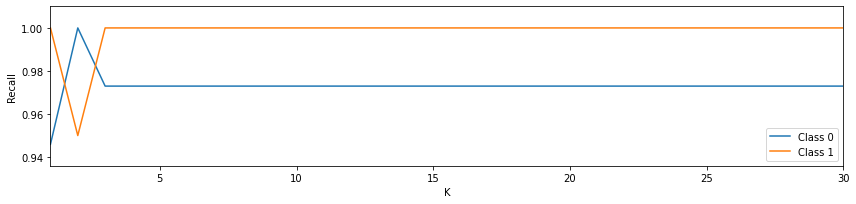

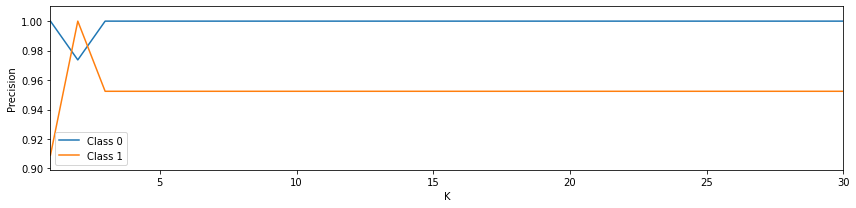

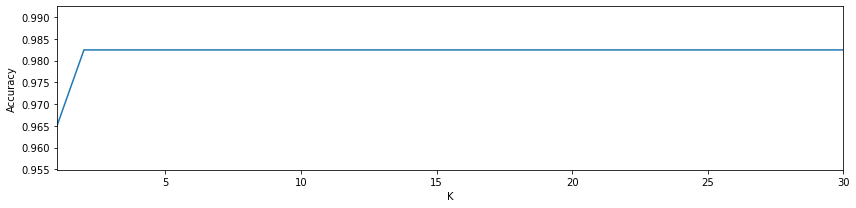

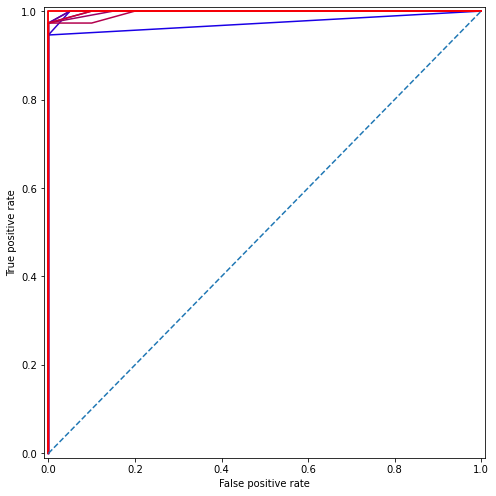

Time elapsed:  4.022758992999798


In [14]:
import time

t0 = time.perf_counter()
X, y = read_cancer_dataset("cancer.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=10)
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1)

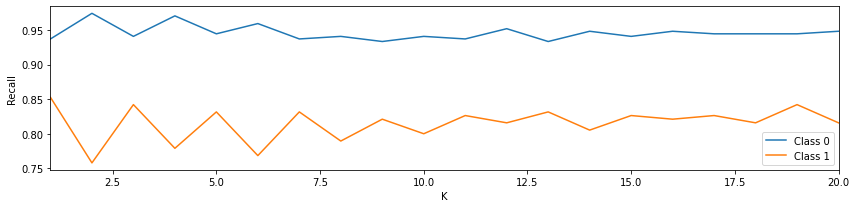

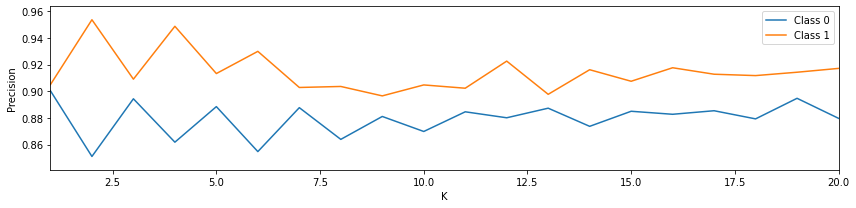

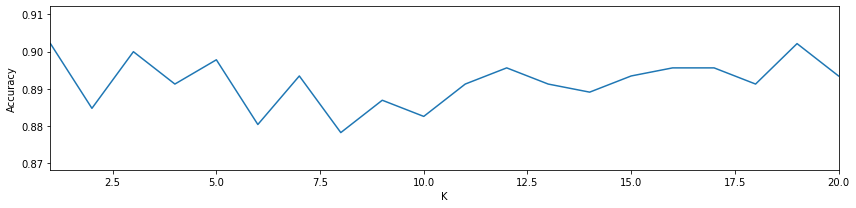

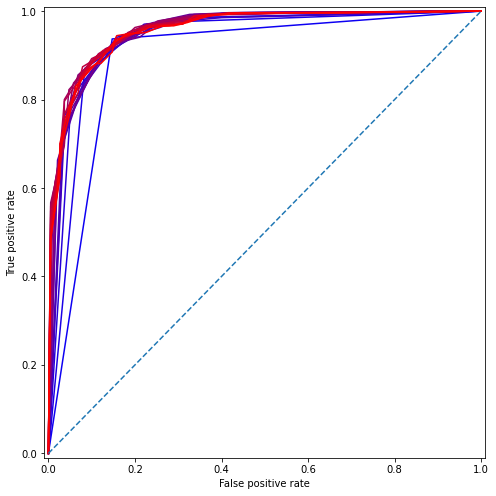

Time elapsed:  124.63902723399997


In [15]:
t0 = time.perf_counter()
X, y = read_spam_dataset("spam.csv")
X_train, y_train, X_test, y_test = train_test_split(X, y, 0.9)
plot_precision_recall(X_train, y_train, X_test, y_test, max_k=20)
plot_roc_curve(X_train, y_train, X_test, y_test, max_k=20)
t1 = time.perf_counter() - t0
print("Time elapsed: ", t1)